In [1]:
import itertools
from copy import deepcopy

import numpy as np
import networkx as nx
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from scipy.stats import beta, dirichlet
import matplotlib.pyplot as plt
import pandas as pd


from model import BaseModel
from true_causal_model import TrueCausalModel
from agents.causal_agents import HalfBlindAgent

%matplotlib inline
np.random.seed(0)

## Entrada: Orden parcial y aristas inválidas

In [15]:
DG = nx.DiGraph([("Reaccion", "Final"), ("Tratamiento", "Reaccion"), ("Tratamiento", "Final"), ("Enfermedad", "Final")])
causal_order = list(nx.topological_sort(DG))
invalid_edges = sorted([("Enfermedad", "Tratamiento")])
print(causal_order)

['Enfermedad', 'Tratamiento', 'Reaccion', 'Final']


## Genero creencias p<sub>ij</sub> iniciales

In [16]:
def is_a_valid_edge(x, y, causal_order, invalid_edges):
    if tuple(sorted((x, y))) in invalid_edges or causal_order.index(y) < causal_order.index(x):
        return False
    return True

In [17]:
def create_pij(variables, causal_order, invalid_edges):
    connection_tables = dict()
    for pair in itertools.combinations((variables), 2):
        proba = np.random.rand()
        if is_a_valid_edge(pair[0], pair[1], causal_order, invalid_edges):
            connection_tables["{}->{}".format(pair[0], pair[1])] = proba
        elif is_a_valid_edge(pair[1], pair[0], causal_order, invalid_edges):
            connection_tables["{}->{}".format(pair[1], pair[0])] = proba
    return connection_tables
def create_ebunch_from_beliefs(variables, connection_tables):
    ebunch = []
    for pair in connection_tables:
        r = np.random.rand()
        if r <= connection_tables[pair]:
            ebunch.append((pair.split('->')[0], pair.split('->')[1]))
    nodes = []
    for v in variables:
        flag = False
        for edge in ebunch:
            if v in edge:
                flag = True
                break
        if not flag:
            nodes.append(v)
    return ebunch, nodes


In [32]:
variables = sorted(["Tratamiento", "Reaccion", "Enfermedad", "Final"])
connection_tables = create_pij(variables, causal_order, invalid_edges)
connection_probas = dict()
for k in connection_tables:
    print(k, connection_tables[k])
    connection_probas[k] = [connection_tables[k]]
ebunch, nodes = create_ebunch_from_beliefs(variables, connection_tables)

print(ebunch)
print(nodes)

Enfermedad->Final 0.7832344383138131
Enfermedad->Reaccion 0.2883984973314939
Reaccion->Final 0.662504571532676
Tratamiento->Final 0.24606318499096447
Tratamiento->Reaccion 0.6658591175591877
[('Enfermedad', 'Final'), ('Reaccion', 'Final')]
['Tratamiento']


## Genero grafo aleatorio e inicializo PGM

/home/ivan/Documentos/playing-against-nature/venv/lib/python3.7/site-packages/pgmpy/factors/discrete/CPD.py:504: UserWarning: Same ordering provided as current
  warn("Same ordering provided as current")


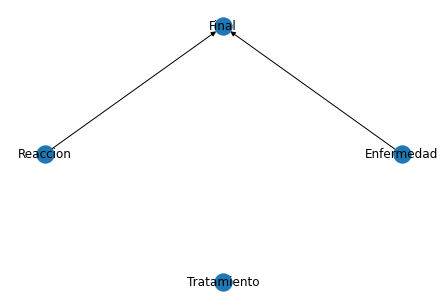

<Figure size 432x288 with 0 Axes>

In [33]:
complete_model = BaseModel('configs/model_parameters.json')
nature = TrueCausalModel(complete_model)
unknown_model = deepcopy(complete_model)
unknown_model.init_graph(ebunch, plot=False)
for node in nodes:
    unknown_model.digraph.add_node(node)
unknown_model.save_digraph_as_img("Nothing")
unknown_model.ebunch = ebunch
unknown_model.pgmodel = BayesianModel(ebunch)
unknown_model.pgmodel.add_nodes_from(nodes)

## Estructura real

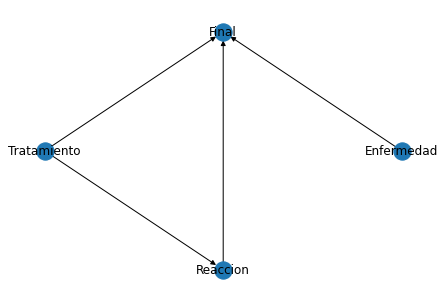

<Figure size 432x288 with 0 Axes>

In [34]:
complete_model.save_digraph_as_img("figures/gt_graph")

## Aprendizaje

In [35]:
agent = HalfBlindAgent(nature, unknown_model)
intervention_vars = agent.model.get_intervention_variables()
target_value = 1
target = {
    "variable": agent.model.get_target_variable(),
    "value" : target_value
}
rounds = 10

In [36]:
def update_connection_beliefs(variable, connection_tables, agent):
    for pair in connection_tables:
        var_one = pair.split("->")[0]
        var_two = pair.split("->")[1]
        nodes_to_remove = set(variables) - set(["Final", "Tratamiento", var_one, var_two])
        aux_model = deepcopy(agent.model)
        aux_model.pgmodel.remove_nodes_from(list(nodes_to_remove))
        aux_model.infer_system = VariableElimination(aux_model.pgmodel)
        p_sub = aux_model.get_joint_prob_observation(nature_response)
        connection_tables[pair] *= p_sub
    return connection_tables

In [37]:
def plot_probabilities(connection_probas):
    i = 4
    for pair in connection_probas:
        plt.plot(connection_probas[pair], marker=i, label=pair)
        i += 1
    plt.legend()
    plt.show()

### Entrenamiento

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 0.7832344383138131
Enfermedad->Reaccion 0.2883984973314939
Reaccion->Final 0.662504571532676
Tratamiento->Final 0.24606318499096447
Tratamiento->Reaccion 0.6658591175591877
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0


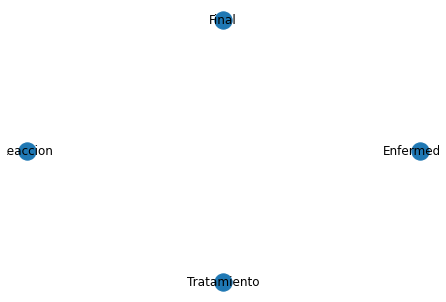

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 0.0011916037350507382
Enfermedad->Reaccion 0.00027425674808930997
Reaccion->Final 0.01792423470842941
Tratamiento->Final 0.04640970066307414
Tratamiento->Reaccion 0.01801499282981161
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0


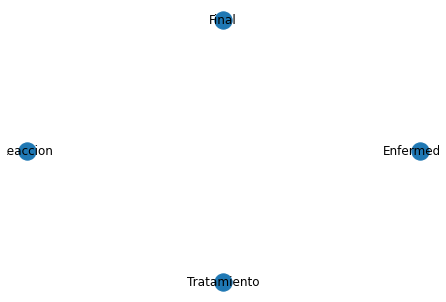

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 2.156824402383764e-05
Enfermedad->Reaccion 2.302705388487872e-06
Reaccion->Final 0.0007764089719878421
Tratamiento->Final 0.004333717204238769
Tratamiento->Reaccion 0.0007803402650593819
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0


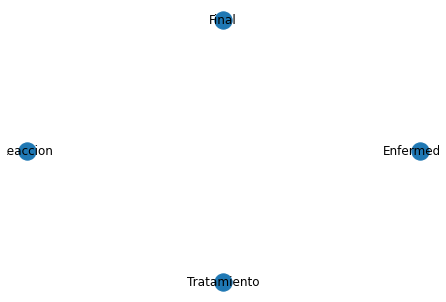

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 4.206010314109088e-146
Enfermedad->Reaccion 4.477010447211969e-147
Reaccion->Final 2.3981411846762375e-91
Tratamiento->Final 1.3426121856936198e-90
Tratamiento->Reaccion 2.4102840065188985e-91
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0


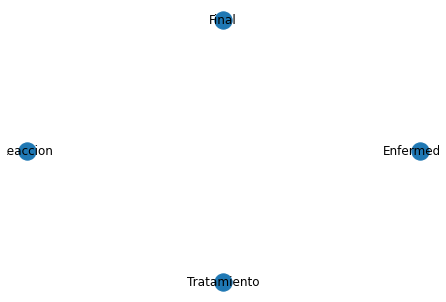

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 2.448057882734053e-146
Enfermedad->Reaccion 7.785560347984152e-148
Reaccion->Final 5.031726330991689e-92
Tratamiento->Final 9.42849620722599e-91
Tratamiento->Reaccion 5.0572041288747635e-92
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0


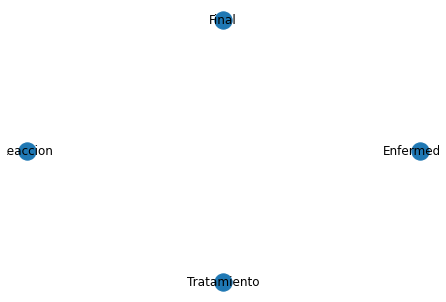

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 6.075400771272634e-152
Enfermedad->Reaccion 1.5914944018763788e-153
Reaccion->Final 3.255725585746675e-92
Tratamiento->Final 7.406469192406483e-91
Tratamiento->Reaccion 3.2722107268254945e-92
+---------------------------------+
Enfermedad = 1
Tratamiento = 0
Reaccion = 0
Final = 1


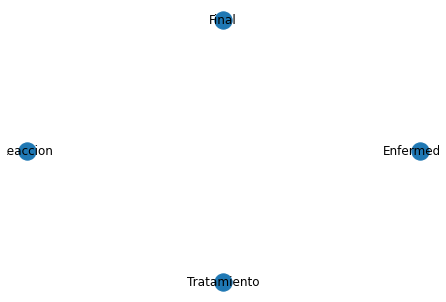

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 2.7436319656296955e-154
Enfermedad->Reaccion 1.6817950303003113e-156
Reaccion->Final 9.233296490758012e-94
Tratamiento->Final 8.976420362719271e-92
Tratamiento->Reaccion 9.280048648230708e-94
+---------------------------------+
Enfermedad = 1
Tratamiento = 0
Reaccion = 0
Final = 1


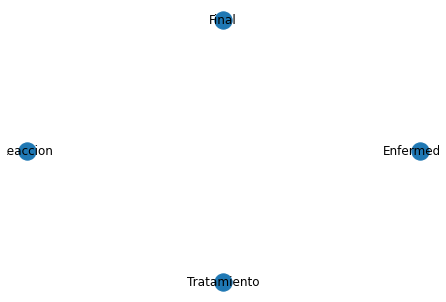

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 2.809605617942025e-161
Enfermedad->Reaccion 2.1637723360342005e-164
Reaccion->Final 5.2534018878022524e-96
Tratamiento->Final 4.065070069672949e-93
Tratamiento->Reaccion 5.280002124518546e-96
+---------------------------------+
Enfermedad = 1
Tratamiento = 0
Reaccion = 0
Final = 1


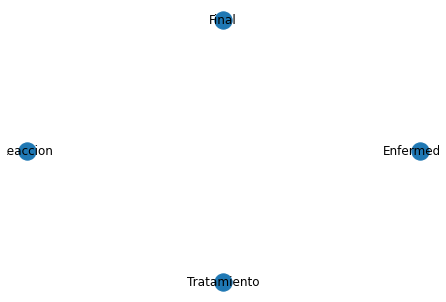

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 5.58599847201402e-166
Enfermedad->Reaccion 2.847727872257799e-169
Reaccion->Final 2.501235228818376e-99
Tratamiento->Final 2.9238189398925177e-96
Tratamiento->Reaccion 2.513900060215377e-99
+---------------------------------+
Enfermedad = 1
Tratamiento = 0
Reaccion = 0
Final = 1


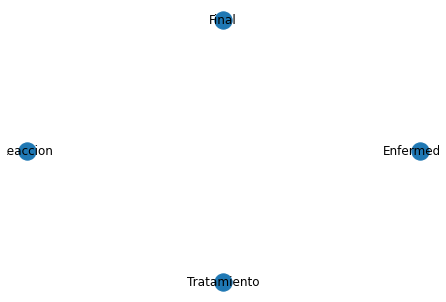

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------------------------------+
Enfermedad->Final 1.0600519943339401e-166
Enfermedad->Reaccion 9.353530959398005e-171
Reaccion->Final 1.263898465155964e-100
Tratamiento->Final 8.536058393252642e-97
Tratamiento->Reaccion 1.2702981275226624e-100
+---------------------------------+
Enfermedad = 0
Tratamiento = 0
Reaccion = 0
Final = 0


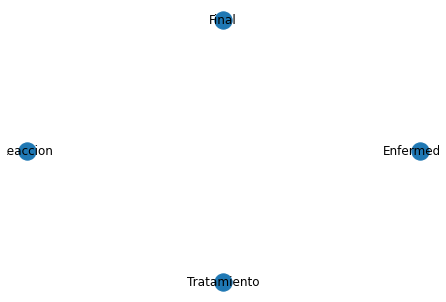

<Figure size 432x288 with 0 Axes>

In [38]:
for rnd in range(rounds):
    print("+---------------------------------+")
    for pair in connection_tables:
        print(pair, connection_tables[pair])
    print("+---------------------------------+")
    best_actions = agent.make_decision(target, intervention_vars)
    nature_response = agent.nature.action_simulator(intervention_vars, best_actions)
    agent.rewards_per_round.append(nature_response[target["variable"]])
    for var in nature_response:
        print("{} = {}".format(var, nature_response[var]))
    connection_tables = update_connection_beliefs(variables, connection_tables, agent)
    for k in connection_tables:
        connection_probas[k] += [connection_tables[k]]
    ebunch, nodes = create_ebunch_from_beliefs(variables, connection_tables)
    unknown_model.init_graph(ebunch, plot=False)
    for node in nodes:
        unknown_model.digraph.add_node(node)
    unknown_model.save_digraph_as_img("Nothing")
    unknown_model.ebunch = ebunch
    unknown_model.pgmodel = BayesianModel(ebunch)
    unknown_model.pgmodel.add_nodes_from(nodes)
    agent = HalfBlindAgent(nature, unknown_model)

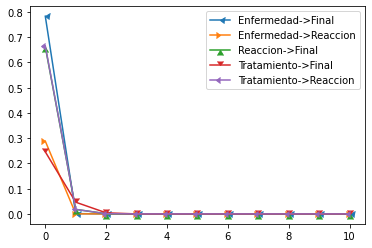

In [39]:
plot_probabilities(connection_probas)